# Set Transformer

## Imports

In [1]:
import torch
from torch.distributions import (Dirichlet, Categorical)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle
import os
import argparse
import logging
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Classes

In [2]:
from scipy.stats import chi2
from matplotlib.patches import Ellipse
import matplotlib.cm as cm

def scatter(X, labels=None, ax=None, colors=None, **kwargs):
    ax = ax or plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    if labels is None:
        ax.scatter(X[:,0], X[:,1], facecolor='k',
                edgecolor=[0.2, 0.2, 0.2], **kwargs)
        return None
    else:
        ulabels = np.sort(np.unique(labels))
        colors = cm.rainbow(np.linspace(0, 1, len(ulabels))) \
                if colors is None else colors
        for (l, c) in zip(ulabels, colors):
            ax.scatter(X[labels==l,0], X[labels==l,1], color=c,
                    edgecolor=c*0.6, **kwargs)
        return ulabels, colors

def draw_ellipse(pos, cov, ax=None, **kwargs):
    if type(pos) != np.ndarray:
        pos = to_numpy(pos)
    if type(cov) != np.ndarray:
        cov = to_numpy(cov)
    ax = ax or plt.gca()
    U, s, Vt = np.linalg.svd(cov)
    angle = np.degrees(np.arctan2(U[1,0], U[0,0]))
    width, height = 2 * np.sqrt(s)
    for nsig in range(1, 6):
        ax.add_patch(Ellipse(pos, nsig*width, nsig*height, angle,
            alpha=0.5/nsig, **kwargs))

def scatter_mog(X, labels, mu, cov, ax=None, colors=None):
    ax = ax or plt.gca()
    ulabels, colors = scatter(X, labels=labels, ax=ax, colors=colors, zorder=10)
    for i, l in enumerate(ulabels):
        draw_ellipse(mu[l], cov[l], ax=ax, fc=colors[i])

In [3]:
class MultivariateNormal(object):
    def __init__(self, dim):
        self.dim = dim

    def sample(self, B, K, labels):
        raise NotImplementedError

    def log_prob(self, X, params):
        raise NotImplementedError

    def stats(self):
        raise NotImplementedError

    def parse(self, raw):
        raise NotImplementedError

class MixtureOfMVNs(object):
    def __init__(self, mvn):
        self.mvn = mvn

    def sample(self, B, N, K, return_gt=False):
        device = 'cpu' if not torch.cuda.is_available() \
                else torch.cuda.current_device()
        pi = Dirichlet(torch.ones(K)).sample(torch.Size([B])).to(device)
        labels = Categorical(probs=pi).sample(torch.Size([N])).to(device)
        labels = labels.transpose(0,1).contiguous()

        X, params = self.mvn.sample(B, K, labels)
        if return_gt:
            return X, labels, pi, params
        else:
            return X

    def log_prob(self, X, pi, params, return_labels=False):
        ll = self.mvn.log_prob(X, params)
        ll = ll + (pi + 1e-10).log().unsqueeze(-2)
        if return_labels:
            labels = ll.argmax(-1)
            return ll.logsumexp(-1).mean(), labels
        else:
            return ll.logsumexp(-1).mean()

    def plot(self, X, labels, params, axes):
        mu, cov = self.mvn.stats(params)
        for i, ax in enumerate(axes.flatten()):
            scatter_mog(X[i].cpu().data.numpy(),
                    labels[i].cpu().data.numpy(),
                    mu[i].cpu().data.numpy(),
                    cov[i].cpu().data.numpy(),
                    ax=ax)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.subplots_adjust(hspace=0.1, wspace=0.1)

    def parse(self, raw):
        return self.mvn.parse(raw)

class MultivariateNormalDiag(MultivariateNormal):
    def __init__(self, dim):
        super(MultivariateNormalDiag, self).__init__(dim)

    def sample(self, B, K, labels):
        N = labels.shape[-1]
        device = labels.device
        mu = -4 + 8*torch.rand(B, K, self.dim).to(device)
        sigma = 0.3*torch.ones(B, K, self.dim).to(device)
        eps = torch.randn(B, N, self.dim).to(device)

        rlabels = labels.unsqueeze(-1).repeat(1, 1, self.dim)
        X = torch.gather(mu, 1, rlabels) + \
                eps * torch.gather(sigma, 1, rlabels)
        return X, (mu, sigma)

    def log_prob(self, X, params):
        mu, sigma = params
        dim = self.dim
        X = X.unsqueeze(2)
        mu = mu.unsqueeze(1)
        sigma = sigma.unsqueeze(1)
        diff = X - mu
        ll = -0.5*math.log(2*math.pi) - sigma.log() - 0.5*(diff.pow(2)/sigma.pow(2))
        return ll.sum(-1)

    def stats(self, params):
        mu, sigma = params
        I = torch.eye(self.dim)[(None,)*(len(sigma.shape)-1)].to(sigma.device)
        cov = sigma.pow(2).unsqueeze(-1) * I
        return mu, cov

    def parse(self, raw):
        pi = torch.softmax(raw[...,0], -1)
        mu = raw[...,1:1+self.dim]
        sigma = F.softplus(raw[...,1+self.dim:])
        return pi, (mu, sigma)

In [4]:
class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        A = torch.softmax(Q_.bmm(K_.transpose(1,2))/math.sqrt(self.dim_V), 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, 'ln0', None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, 'ln1', None) is None else self.ln1(O)
        return O

class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False):
        super(SAB, self).__init__()
        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(X, X)

class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)
        self.mab0 = MAB(dim_out, dim_in, dim_out, num_heads, ln=ln)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln)

    def forward(self, X):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X)
        return self.mab1(X, H)

class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)
        self.mab = MAB(dim, dim, dim, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X)

In [5]:
class SetTransformer(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output,
            num_inds=32, dim_hidden=128, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()
        self.enc = nn.Sequential(
                ISAB(dim_input, dim_hidden, num_heads, num_inds, ln=ln),
                ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln))
        self.dec = nn.Sequential(
                PMA(dim_hidden, num_heads, num_outputs, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                SAB(dim_hidden, dim_hidden, num_heads, ln=ln),
                nn.Linear(dim_hidden, dim_output))

    def forward(self, X):
        return self.dec(self.enc(X))

## Functions

In [6]:
def generate_benchmark():
    if not os.path.isdir('benchmark'):
        os.makedirs('benchmark')
    N_list = np.random.randint(N_min, N_max, num_bench)
    data = []
    ll = 0.
    for N in tqdm(N_list):
        X, labels, pi, params = mog.sample(B, N, K, return_gt=True)
        ll += mog.log_prob(X, pi, params).item()
        data.append(X)
    bench = [data, ll/num_bench]
    torch.save(bench, benchfile)

def train():
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

    if not os.path.isfile(benchfile):
        generate_benchmark()

    bench = torch.load(benchfile)
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(run_name)
    logger.addHandler(logging.FileHandler(
        os.path.join(save_dir,
            'train_'+time.strftime('%Y%m%d-%H%M')+'.log'),
        mode='w'))

    optimizer = optim.Adam(net.parameters(), lr=lr)
    tick = time.time()
    for t in range(1, num_steps+1):
        if t == int(0.5*num_steps):
            optimizer.param_groups[0]['lr'] *= 0.1
        net.train()
        optimizer.zero_grad()
        N = np.random.randint(N_min, N_max)
        X = mog.sample(B, N, K)
        ll = mog.log_prob(X, *mvn.parse(net(X)))
        loss = -ll
        loss.backward()
        optimizer.step()

        if t % test_freq == 0:
            line = 'step {}, lr {:.3e}, '.format(
                    t, optimizer.param_groups[0]['lr'])
            line += test(bench, verbose=False)
            line += ' ({:.3f} secs)'.format(time.time()-tick)
            tick = time.time()
            logger.info(line)

        if t % save_freq == 0:
            torch.save({'state_dict':net.state_dict()},
                    os.path.join(save_dir, 'model.tar'))

    torch.save({'state_dict':net.state_dict()},
        os.path.join(save_dir, 'model.tar'))

def test(bench, verbose=True):
    net.eval()
    data, oracle_ll = bench
    avg_ll = 0.
    for X in data:
        X = X.cuda()
        avg_ll += mog.log_prob(X, *mvn.parse(net(X))).item()
    avg_ll /= len(data)
    line = 'test ll {:.4f} (oracle {:.4f})'.format(avg_ll, oracle_ll)
    if verbose:
        logging.basicConfig(level=logging.INFO)
        logger = logging.getLogger(run_name)
        logger.addHandler(logging.FileHandler(
            os.path.join(save_dir, 'test.log'), mode='w'))
        logger.info(line)
    return line

def plot():
    net.eval()
    X = mog.sample(B, np.random.randint(N_min, N_max), K)
    pi, params = mvn.parse(net(X))
    ll, labels = mog.log_prob(X, pi, params, return_labels=True)
    fig, axes = plt.subplots(2, B//2, figsize=(7*B//5,5))
    mog.plot(X, labels, params, axes)
    plt.show()

In [7]:
B = 10
K = 4
D = 2
mvn = MultivariateNormalDiag(D)
mog = MixtureOfMVNs(mvn)
dim_output = 2*D
N_min = 300
N_max = 600

num_bench = 100
num_steps = 50000
test_freq = 200
save_freq = 400

run_name = "trial"
lr = 1e-3
save_dir = os.path.join('results')
benchfile = os.path.join('benchmark', 'mog_{:d}.pkl'.format(K))


net = SetTransformer(D, K, dim_output).cuda()

In [8]:
N = np.random.randint(N_min, N_max)
X = mog.sample(B, N, K)

In [10]:
X.shape

torch.Size([10, 336, 2])

In [40]:
train()

100%|███████████████████████████████████████████████████| 100/100 [00:00<00:00, 573.85it/s]
/tmp/ipykernel_3100/3320670648.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/tmp/ipykernel_3100/3030522791.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(save_dir, 'model.tar'))


TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

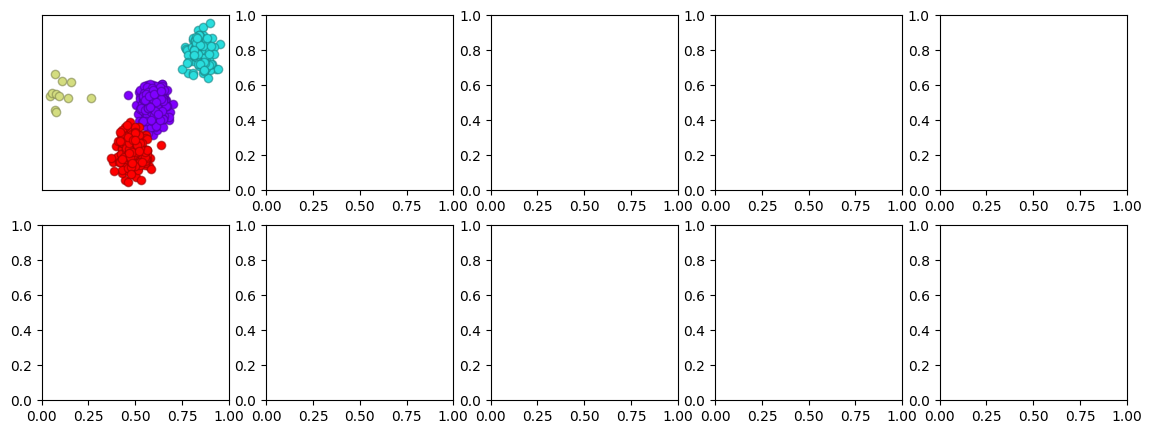

In [41]:
ckpt = torch.load(os.path.join(save_dir, 'model.tar'))
net.load_state_dict(ckpt['state_dict'])
plot()